(rv)=

# Radial velocity fitting

In [310]:
import sys
sys.version

'3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) \n[Clang 11.1.0 ]'

In [311]:
import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


Fitting RVs for Earth and Jupiter

In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000- T_subtract
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000- T_subtract
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:313: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:387: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


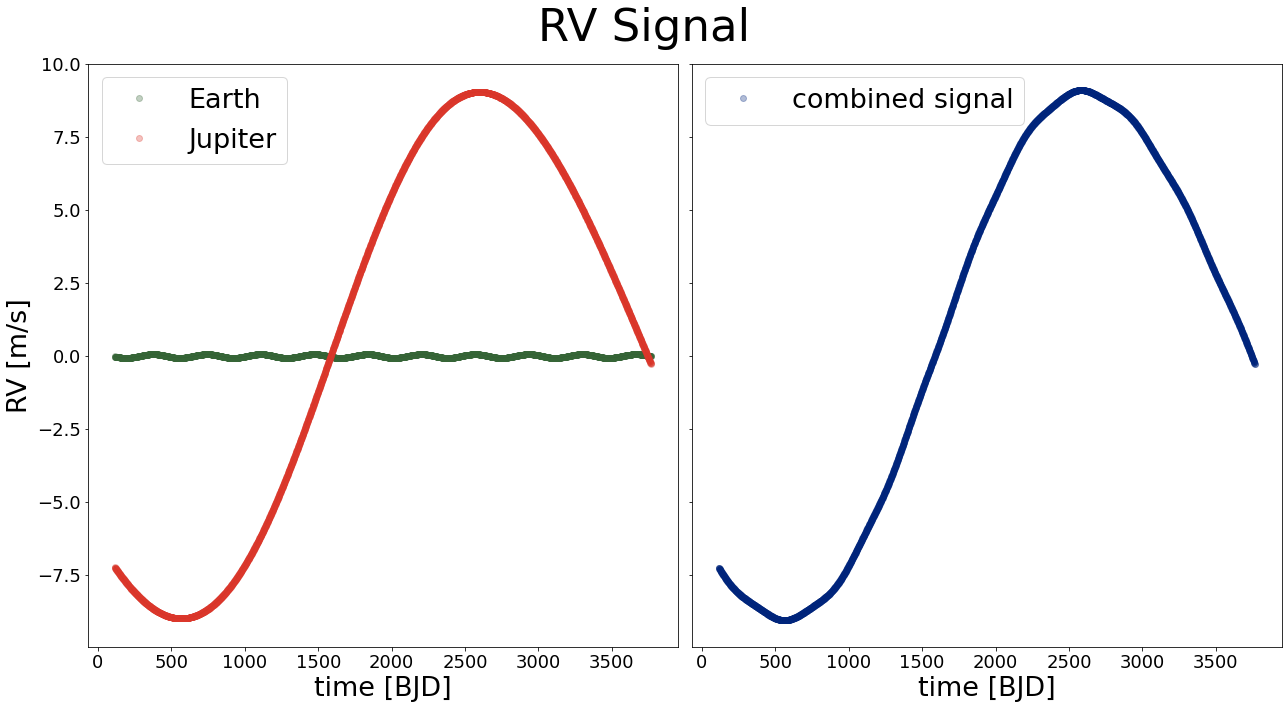

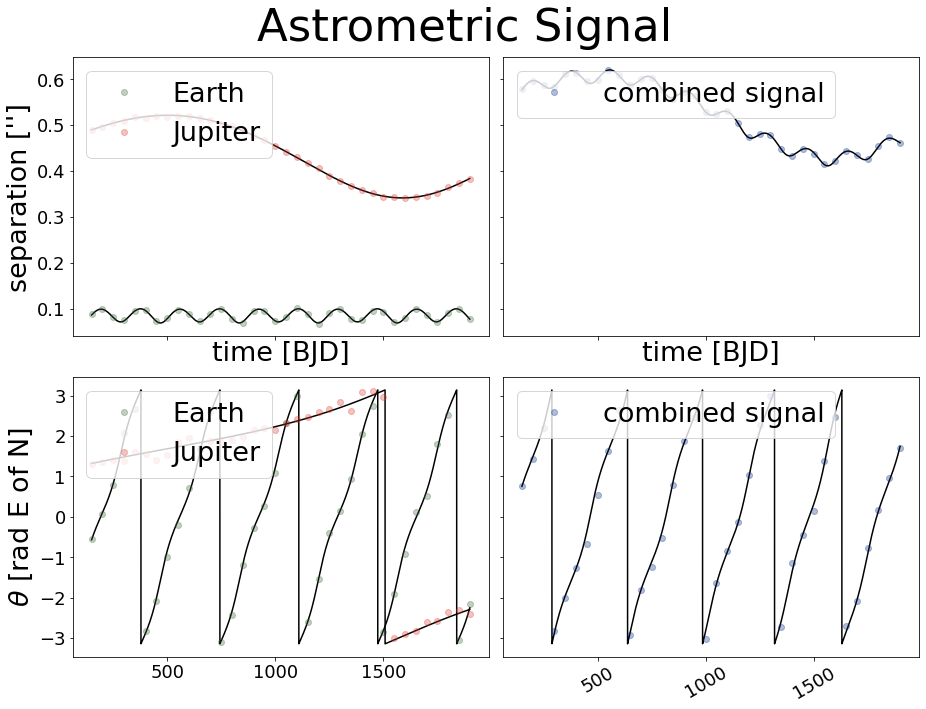

In [358]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]

orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1800):
    if ii % 50 == 0:
        times_observed_astrometry.append(ii)

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.001

sigma_theta = 0.1
sigma_rho = 0.001
parallax = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    parallax,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



<ErrorbarContainer object of 3 artists>

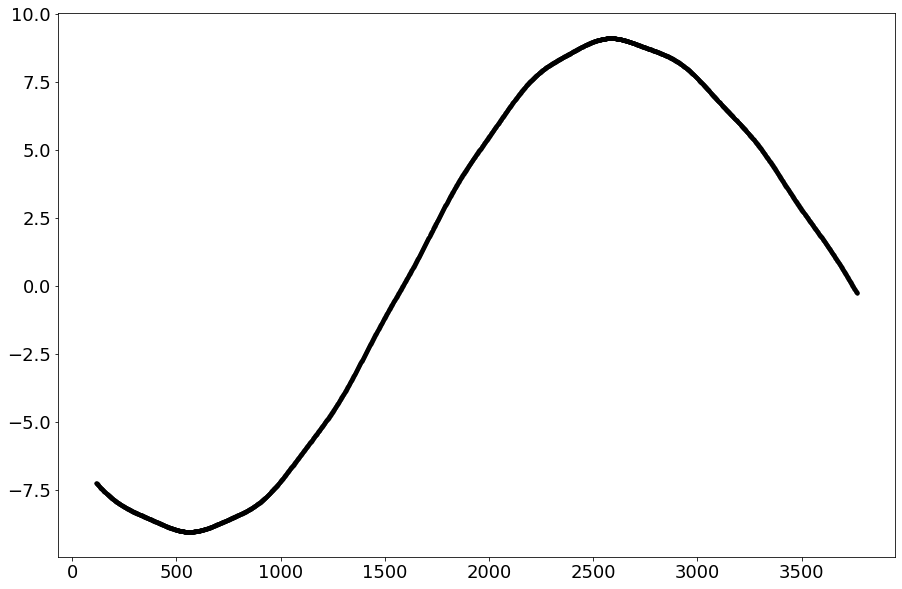

In [359]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    parallax,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results





x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), .01)


# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = '.', color = 'k')

We will have a sense of the periods of the planets, so we can use the `exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [360]:
periods = [365.3, 4327.5]
tperis = [2454115 - T_subtract, 2455633 - T_subtract]
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err)
print(Ks, "m/s")

[0.04941265 9.09090186] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3.
First, we'll define our priors on the parameters:

In [361]:
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:
    
    ##  wide uniform prior on t_periastron
    tperi = pm.Normal("tperi", mu=np.array(tperis), sd=50.0, shape=2, testval = tperis)
    
    #log normal prior on period around estimates

    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=2.0,
        shape=2,
        testval=np.log(periods),
    )
    


    P = pm.Deterministic("P", tt.exp(logP))
    
    
    # Wide normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks))
    
    K = pm.Deterministic("K", tt.exp(logK))
    
    
    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    #xo.eccentricity.vaneylen19(
    #    "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
    #)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=0.01)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=tperi, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=K)
        pm.Deterministic("vrad" + name, vrad)

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))

    # Define the RVs at the observed times
    rv_model = get_rv_model(x_rv)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

Now, we can plot the initial model:

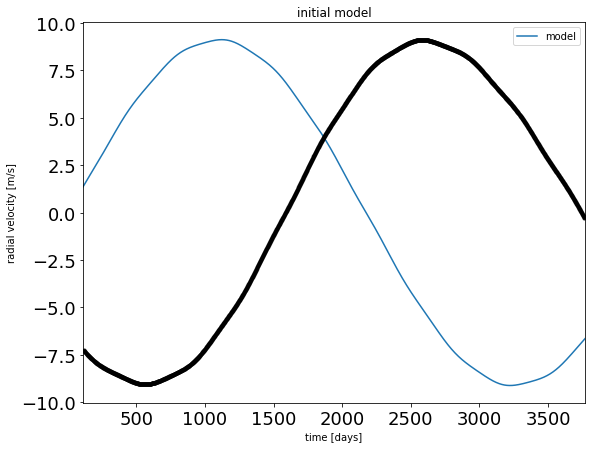

In [362]:
plt.figure(figsize=[9,7])
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha=0.5)
with model:
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [363]:
with model:
    print(pmx.eval_in_model(model.tperi))
    print(pmx.eval_in_model(model.P))
    print(pmx.eval_in_model(model.K))
    print(pmx.eval_in_model(model.ecc))
    print(pmx.eval_in_model(model.omega))
    
print("")
print(Tper_earth, Tper_jup)
print(P_earth, P_jup)
print(K_earth, K_jup)
print(e_earth, e_jup)
print(omega_earth, omega_jup)

[ 115. 1633.]
[ 365.3 4327.5]
[0.04941265 9.09090186]
[0.0002 0.0002]
[0.78539816 0.78539816]

115.52083329996094 1633.721527799964
365.256 4327.631
0.06324910114552053 9.020785051203053
0.0167 0.0484
1.7959438003021653 -1.4957471689591397


In this plot, the full model is the blue line and the data are the black points

It looks pretty good already, but let's still fit for the maximum a posterior parameters.

In [ ]:
with model:
    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars=[ecs, K, P])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [logP, logK, ecs]


Text(0.5, 1.0, 'MAP model only')

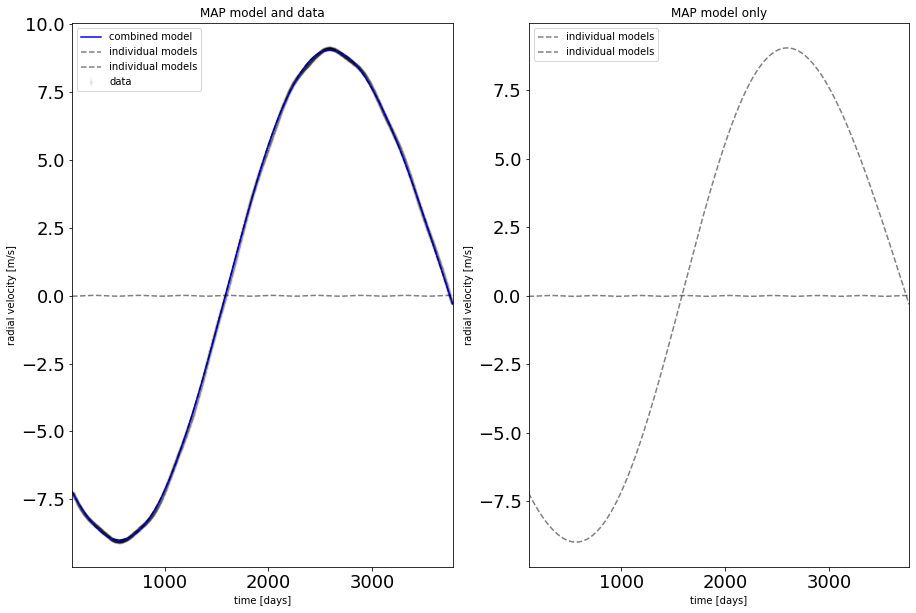

In [320]:
fig, ax = plt.subplots(1,2, figsize = [15,10])

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax[0].plot(t, map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax[0].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")


ax[1].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")
ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")


That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [321]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        start = map_soln
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, ecs, logK, logP, tperi]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 175 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7719366695651186, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [322]:
import arviz as az

az.summary(
    trace, var_names=["logs", "omega", "ecc", "tperi", "K", "P", "ecs"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logs,-3.910,0.007,-3.926,-3.898,0.001,0.001,40.0,53.0,1.04
omega[0],-0.123,2.472,-3.059,3.060,0.150,0.401,1112.0,1519.0,1.07
omega[1],-1.495,0.001,-1.498,-1.493,0.000,0.000,99.0,276.0,1.02
ecc[0],0.034,0.024,0.001,0.076,0.002,0.001,76.0,69.0,1.02
ecc[1],0.049,0.000,0.049,0.049,0.000,0.000,431.0,967.0,1.02
tperi[0],131.390,58.676,34.336,235.427,13.924,11.548,20.0,32.0,1.07
tperi[1],1633.880,0.977,1632.043,1635.680,0.098,0.069,102.0,280.0,1.02
K[0],0.015,0.001,0.014,0.016,0.000,0.000,319.0,1143.0,1.01
K[1],9.021,0.001,9.020,9.022,0.000,0.000,253.0,1041.0,1.01
P[0],427.083,0.648,426.015,428.402,0.043,0.030,258.0,891.0,1.01


<ipython-input-323-519f1a6963eb>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=["logs", "P", "K", "ecc", "omega", "tperi"])


array([[<AxesSubplot:title={'center':'logs'}>,
        <AxesSubplot:title={'center':'logs'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'K'}>,
        <AxesSubplot:title={'center':'K'}>],
       [<AxesSubplot:title={'center':'ecc'}>,
        <AxesSubplot:title={'center':'ecc'}>],
       [<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'tperi'}>,
        <AxesSubplot:title={'center':'tperi'}>]], dtype=object)

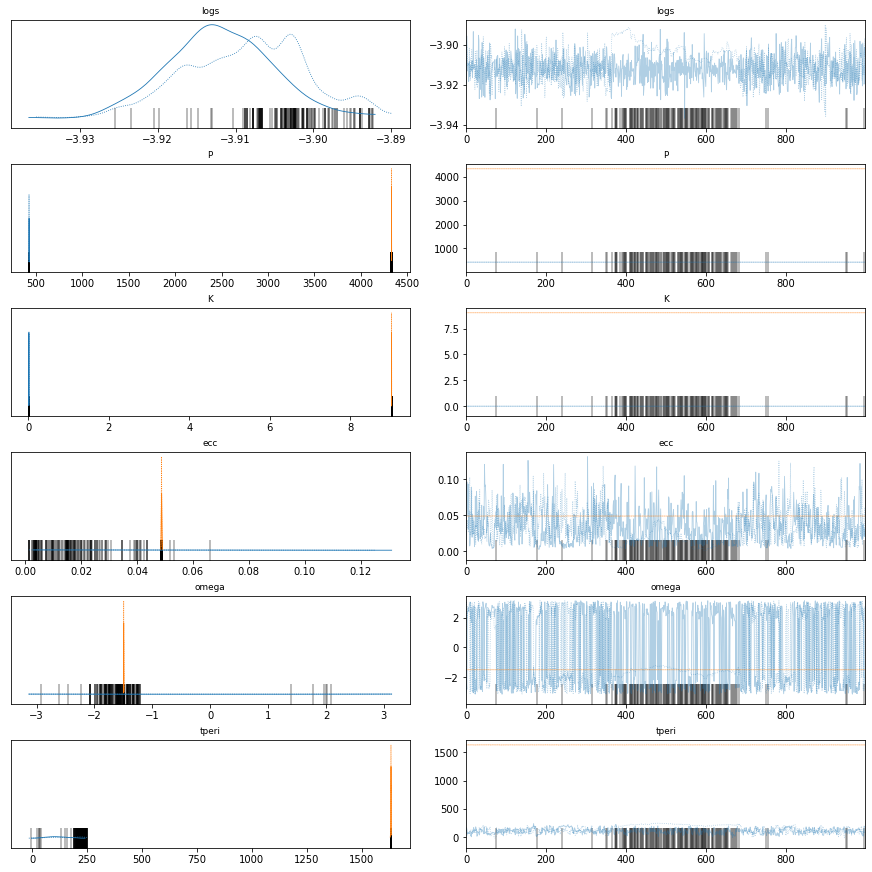

In [323]:
pm.traceplot(trace, var_names=["logs", "P", "K", "ecc", "omega", "tperi"])


It looks like everything is pretty much converged here. 

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

In [324]:
from astropy.constants import M_sun
print(M_sun)

  Name   = Solar mass
  Value  = 1.988409870698051e+30
  Uncertainty  = 4.468805426856864e+25
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2018


In [325]:
from astropy import constants

def a_from_Kepler3(period, M_tot):
    period = period*86400 #days to seconds
    

    M_tot = M_tot*M_sun.value #solar masses to kg
    
    a3 = ( ((constants.G.value)*M_tot) / (4*np.pi**2) ) * (period)**2.
    
    a = a3**(1/3)
    
    
    
    a = a * 6.68459*10**(-12.) # meters to AU
    
    return(a) #in AUs

In [326]:
from astropy.constants import M_sun, G


def semi_amplitude(m_planet, a, ecc, inclination):
    K = \
    np.sqrt(G / (1-(ecc**2.))) * ((m_planet*M_sun)*np.sin(inclination)) * \
    ((M_sun+(m_planet*M_sun))** (-(1./2.))) * \
    (a*u.AU.to(u.m))  ** ((-1./2.))
    
    return K.value
    



In [327]:
a_true_earth = a_from_Kepler3(P_earth, 1.0+m_earth)
a_true_jup = a_from_Kepler3(P_jup, 1.0+m_jup)

K_earth = semi_amplitude(m_earth, a_true_earth, e_earth, inclination_earth)
K_jup = semi_amplitude(m_jup, a_true_jup, e_jup, inclination_jup)

print(K_earth)
print(K_jup)

0.06324910114552053
9.020785051203053


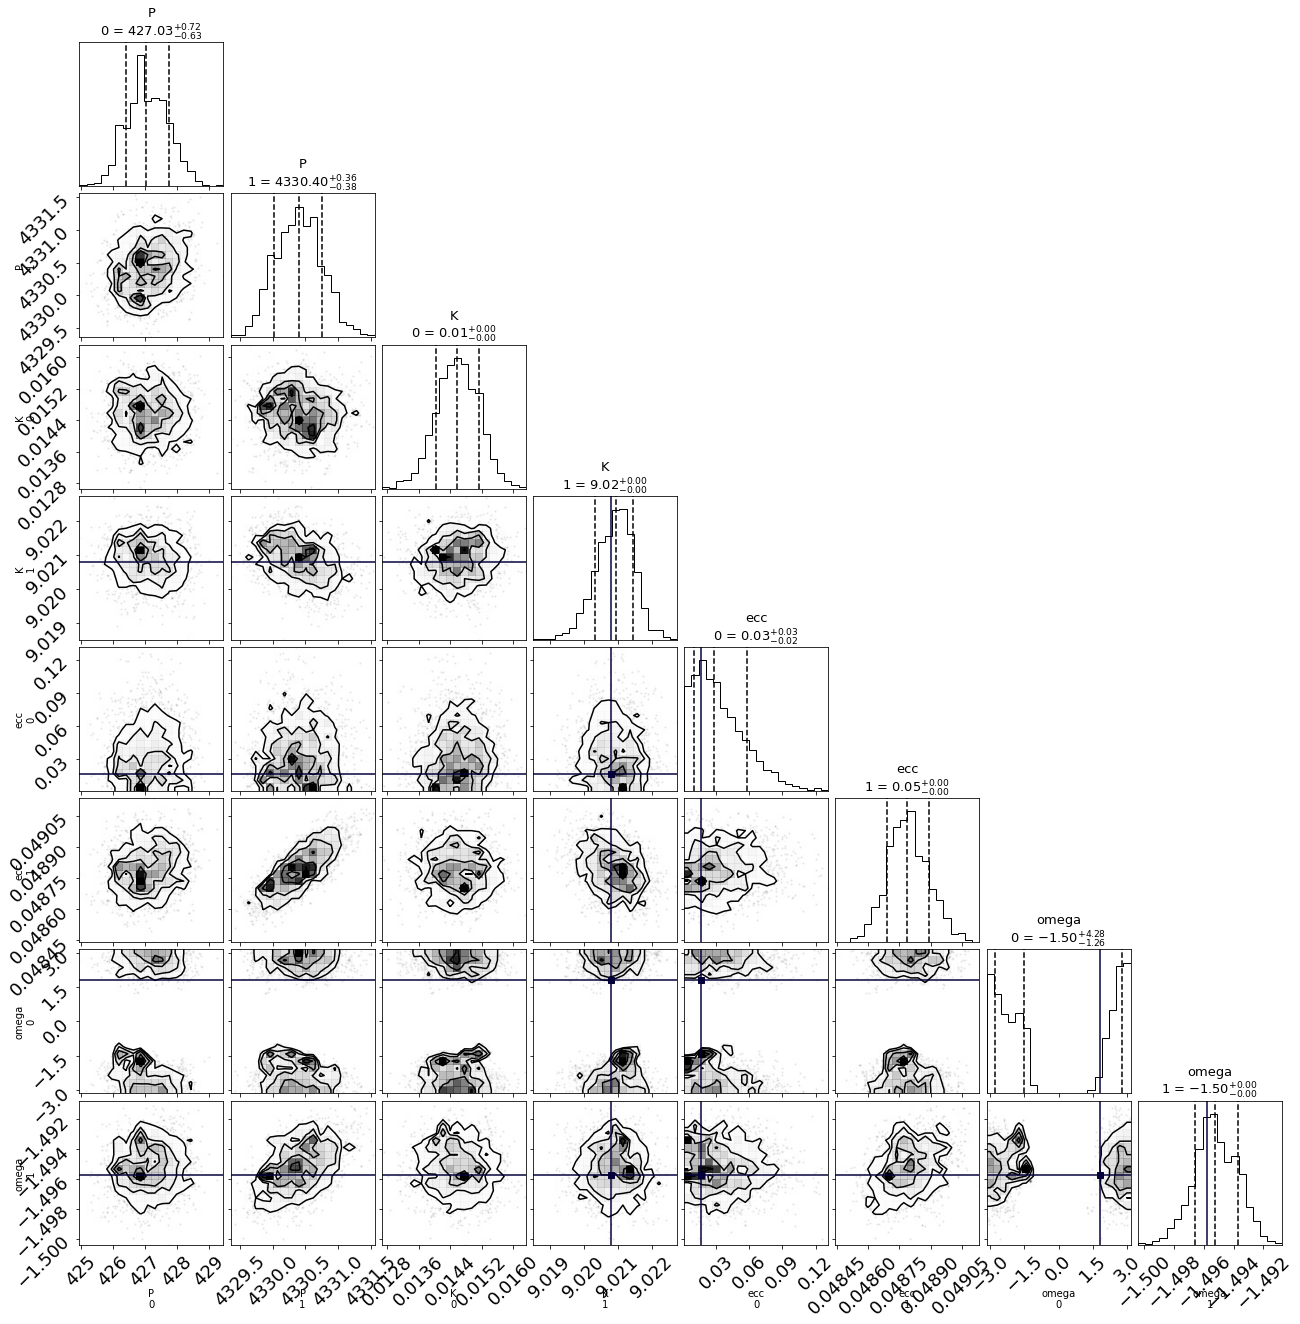

In [328]:
import corner

truth = [P_earth, P_jup, K_earth, K_jup, e_earth, e_jup, omega_earth, omega_jup]
with model:
    _ = corner.corner(trace, var_names=["P", "K", "ecc", "omega"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}, truths = truth, truth_color = "#03003a")

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

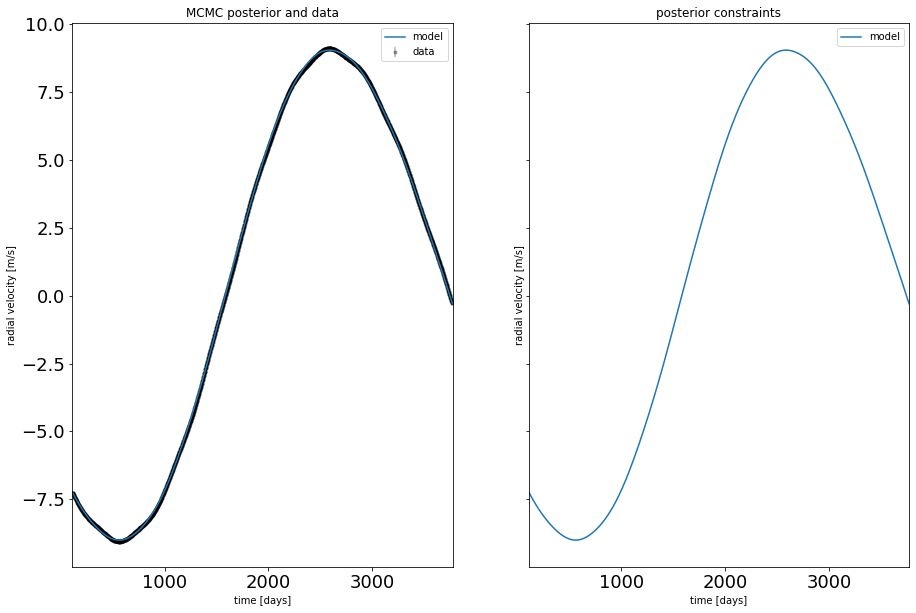

In [329]:
# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))

fig, ax = plt.subplots(1,2, figsize = [15,10], sharey=True)

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.3, label='data', zorder = 0)
ax[0].plot(t, pred[1], color="C0", label="model", zorder = 1)
art = ax[0].fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MCMC posterior and data")




ax[1].plot(t, pred[1], color="C0", label="model")
art = ax[1].fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")



plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

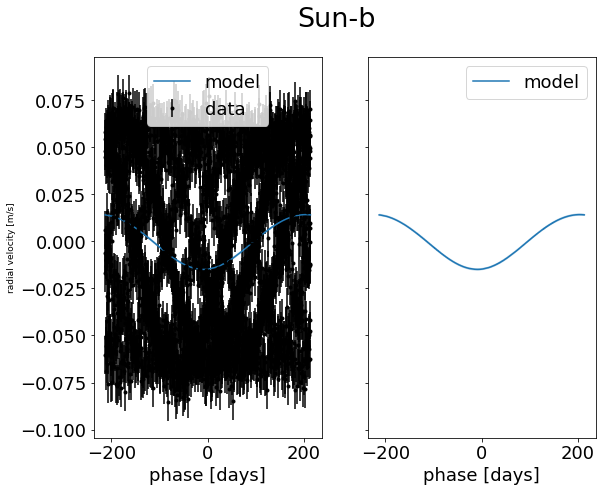

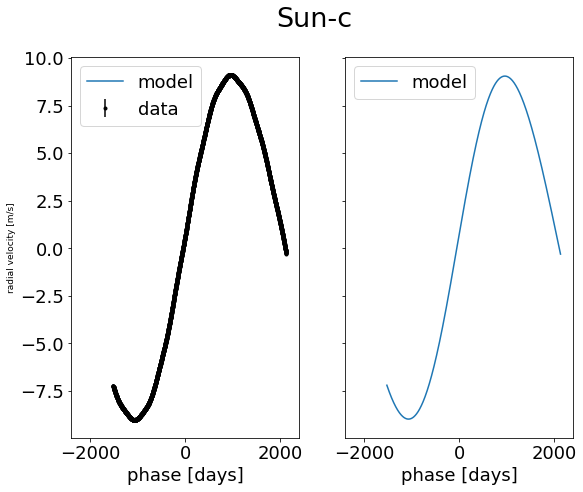

In [330]:
for n, letter in enumerate("bc"):
    fig, ax = plt.subplots(1,2, figsize = [9,7], sharey=True)
    ax0, ax1 = ax[0], ax[1]
    
    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    tperi = np.median(trace.posterior["tperi"].values[:, :, n])

    # Compute the median of posterior estimate the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )

    # Plot the folded data
    x_fold = (x_rv - tperi + 0.5 * p) % p - 0.5 * p
    ax0.errorbar(x_fold, y_rv - other, yerr=y_rv_err, fmt=".k", label = "data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - tperi + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    ax0.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = ax0.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")
    
    
    
    
    
    
    ax1.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = ax1.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    ax0.legend(fontsize=18)
    ax1.legend(fontsize=18)
    plt.xlim(-0.5 * p, 0.5 * p)
    ax0.set_xlabel("phase [days]", fontsize=18)
    ax1.set_xlabel("phase [days]", fontsize=18)
    ax0.set_ylabel("radial velocity [m/s]", fontsize=9)
    ax0.set_ylabel("radial velocity [m/s]", fontsize=9)
    ax0.set_xlim(-p/1.8, p/1.8)
    ax1.set_xlim(-p/1.8, p/1.8)
    fig.suptitle("Sun-{0}".format(letter), fontsize=27)

In [331]:
parameters = ["P", "K", "ecc", "omega", "tperi"]
param_medians = {}
param_std = {}
posterior1 = {}
posterior2 = {}
for param in parameters:
    posterior1[param]=np.concatenate(trace.posterior[param].values[:, :, 0])
    posterior2[param]=np.concatenate(trace.posterior[param].values[:, :, 1])
    
    print(param + " median")
    planet1_med = np.median(trace.posterior[param].values[:, :, 0])
    planet2_med = np.median(trace.posterior[param].values[:, :, 1])
    print(planet1_med)
    print(planet2_med)
    print("")
    
    print(param + " stdev")
    planet1_std = np.std(trace.posterior[param].values[:, :, 0])
    planet2_std = np.std(trace.posterior[param].values[:, :, 1])
    print(planet1_std)
    print(planet2_std)
    
    param_medians[param]=[planet1_med, planet2_med]
    param_std[param]=[planet1_std, planet2_std]
    print("")
    print("")

P median
427.0293994777737
4330.396200802234

P stdev
0.6479331795621797
0.3579184917350773


K median
0.014583634457170608
9.020942313339027

K stdev
0.0005427198264475444
0.0005635935673176092


ecc median
0.02866866602700257
0.04878794817573047

ecc stdev
0.023612117471356536
9.960998972831234e-05


omega median
-1.5013774985750288
-1.4952744802811544

omega stdev
2.4712606730178575
0.0014577790622196025


tperi median
125.37259849635632
1633.844113250596

tperi stdev
58.66156122927349
0.976827602579313




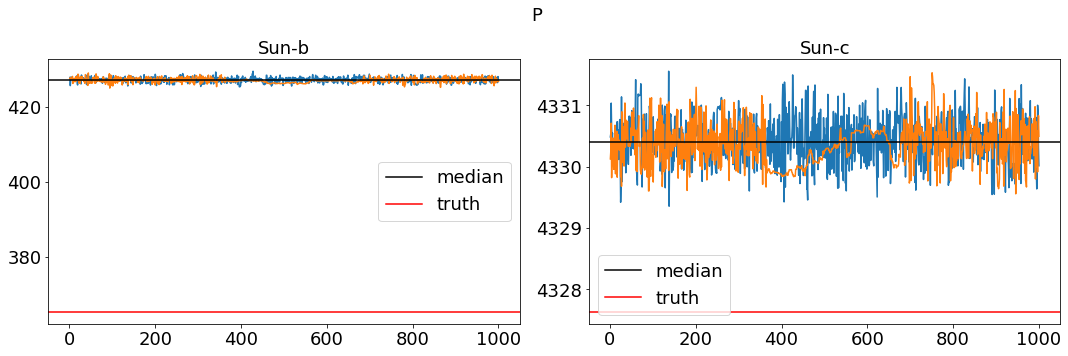

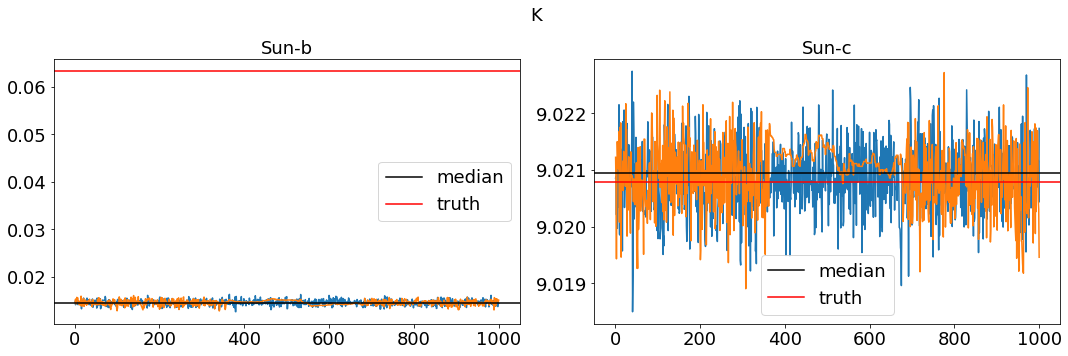

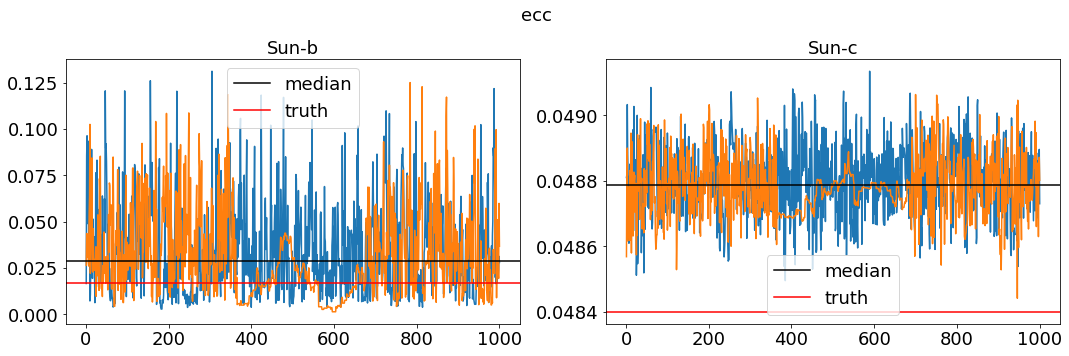

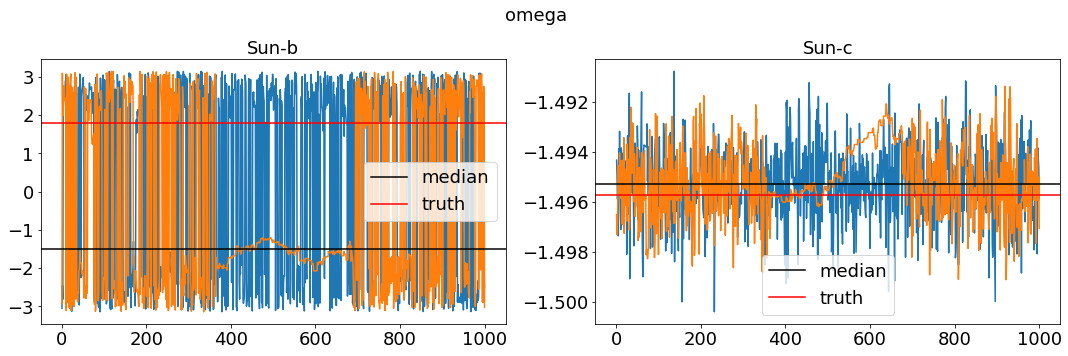

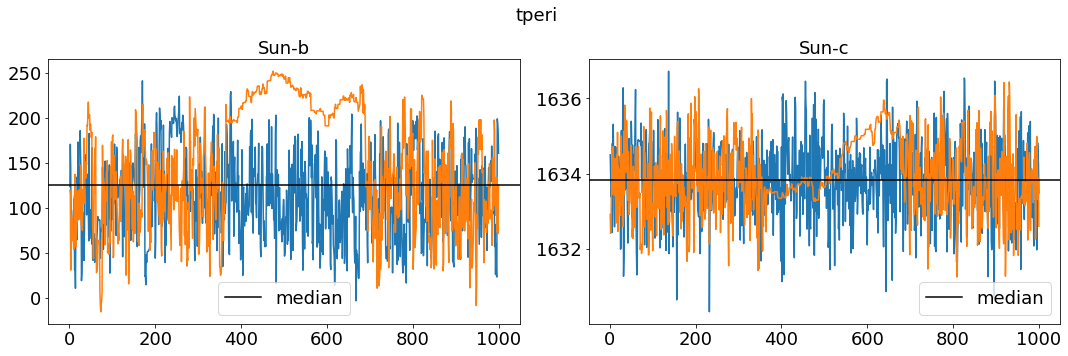

In [332]:
parameters = ["P", "K", "ecc", "omega", "tperi"]
for ii in range(0, len(parameters)):
    plot_truth = False
    param = parameters[ii]
    
    if ii < 4:
        true_vals_earth = truth[2*ii]
        true_vals_jup = truth[2*ii+1]
        plot_truth = True
    
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    planet1_chain1 = trace.posterior[param].values[:, :, 0][0]
    planet1_chain2 = trace.posterior[param].values[:, :, 0][1]
    
    planet2_chain1 = trace.posterior[param].values[:, :, 1][0]
    planet2_chain2 = trace.posterior[param].values[:, :, 1][1]
    
    
    nstep = np.arange(1, len(planet1_chain1)+1, 1)
    
    
    ax[0].plot(nstep, planet1_chain1)
    ax[0].plot(nstep, planet1_chain2)
    ax[0].axhline(y=param_medians[param][0], color = 'k', label = 'median')
    
    if plot_truth:
        ax[0].axhline(y=true_vals_earth, color = 'r', label = 'truth')
    ax[0].set_title("Sun-b", fontsize = 18)
    ax[0].legend(fontsize = 18)
    
    ax[1].plot(nstep, planet2_chain1)
    ax[1].plot(nstep, planet2_chain2)
    ax[1].axhline(y=param_medians[param][1], color = 'k', label = 'median')
    
    if plot_truth:
        ax[1].axhline(y=true_vals_jup, color = 'r', label = 'truth')
    ax[1].set_title("Sun-c", fontsize = 18)
    ax[1].legend(fontsize = 18)

    fig.suptitle(param, fontsize = 18)
    fig.tight_layout()
    plt.show()

Ok, now let's fold in astrometric observations

(astrometric)=

# Astrometric fitting

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

Text(0.5, 0, 'time [years]')

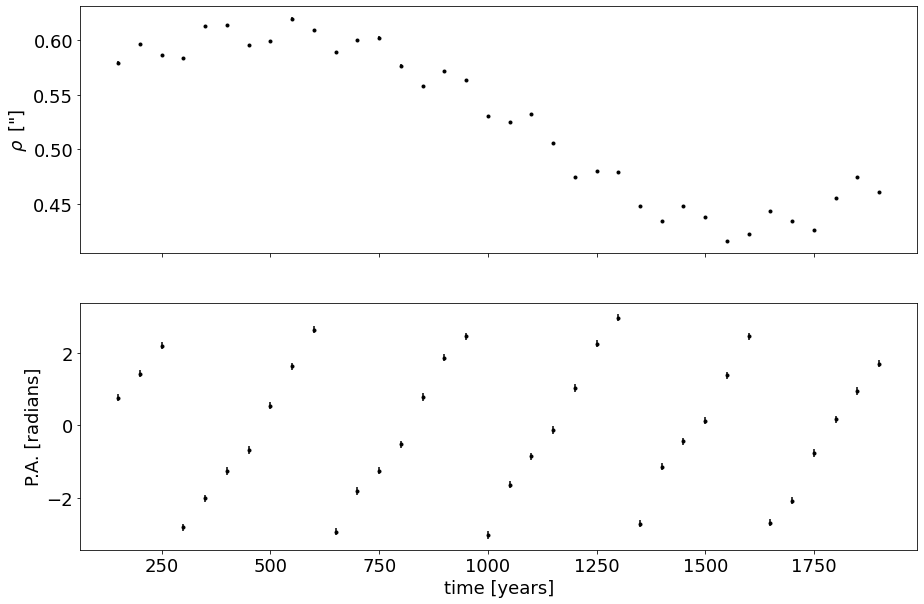

In [333]:

x_astrometry = np.array(times_observed_astrometry)
theta_data = theta_sim_sum
theta_err = np.full(np.shape(theta_data), .1)
rho_data = rho_sim_sum
rho_err = np.full(np.shape(rho_data), .001)


# Also make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)


fig,ax = plt.subplots(2, figsize=[15,10], sharex=True)

ax[0].errorbar(x_astrometry, rho_data, yerr=rho_err, ls = '', marker = '.', color = 'k')
ax[0].set_ylabel(r'$\rho\,$ ["]', fontsize = 18)

ax[1].errorbar(x_astrometry, theta_data, yerr=theta_err, ls = '', marker = '.', color = 'k')
ax[1].set_ylabel(r"P.A. [radians]", fontsize = 18)
ax[1].set_xlabel("time [years]", fontsize = 18)






## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

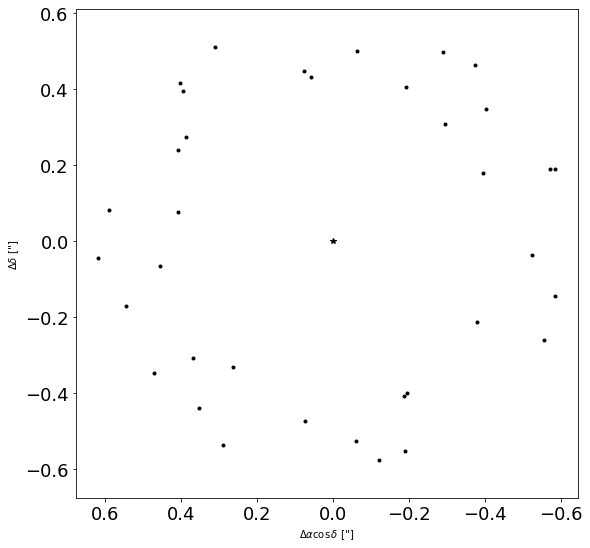

In [334]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(9, 9))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")





## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample.

In [335]:
print(param_medians)





{'P': [427.0293994777737, 4330.396200802234], 'K': [0.014583634457170608, 9.020942313339027], 'ecc': [0.02866866602700257, 0.04878794817573047], 'omega': [-1.5013774985750288, -1.4952744802811544], 'tperi': [125.37259849635632, 1633.844113250596]}


In [336]:
P_RV = np.array(param_medians['P'])
K_RV = np.array(param_medians['K'])
tperi_RV = np.array(param_medians['tperi'])
ecc_RV = np.array(param_medians['ecc'])
omega_RV = np.array(param_medians['omega'])


P_RV_std = np.array(param_std['P'])
K_RV_std = np.array(param_std['K'])
tperi_RV_std = np.array(param_std['tperi'])
ecc_RV_std = np.array(param_std['ecc'])
omega_RV_std = np.array(param_std['omega'])


print(P_RV)
print(P_RV_std)

[ 427.02939948 4330.3962008 ]
[0.64793318 0.35791849]


In [337]:
#determine minimum mass estimate

m_sun = 333030
def min_mass(K, period, ecc):
    m_planet = K/((333030*m_jup)*28.4329/(np.sqrt(1-ecc**2.)) \
                  *(m_sun)**(-2/3) * (period / 365.256) ** (-1/3))

    return m_planet/m_sun



In [338]:

min_masses_RV = min_mass(K_RV, P_RV, ecc_RV)
print(min_masses_RV*m_sun)
print(min_mass(truth[2], truth[0], truth[4])*m_sun)
print(min_mass(truth[3], truth[1], truth[5])*m_sun)





[8.16483194e-03 1.09232297e+01]
0.033622784344753694
10.920920136165659


In [339]:
print(truth)
P_true  = np.array(truth[0:2])
tper_true  = np.array([Tper_earth, Tper_jup])
ecc_true  = np.array(truth[4:6])
omega_true  = np.array(truth[6:8])
min_mass_true = np.array([min_mass(truth[2], truth[0], truth[4]), 
                          min_mass(truth[3], truth[1], truth[5])])

[365.256, 4327.631, 0.06324910114552053, 9.020785051203053, 0.0167, 0.0484, 1.7959438003021653, -1.4957471689591397]


In [340]:

from aesara_theano_fallback import aesara as theano

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the parameter estimates from our 
# RV fit and from the true parameters. On both of these, the assumption (bc no inclination )


# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    t_periastron=tperi_RV, period=P_RV, ecc=ecc_RV, omega=omega_RV, m_p = min_masses_RV)

orbit_true = xo.orbits.KeplerianOrbit(
    t_periastron=tper_true, period=P_true, ecc=ecc_true, omega=omega_true, 
    m_p = np.array([min_mass_true]))



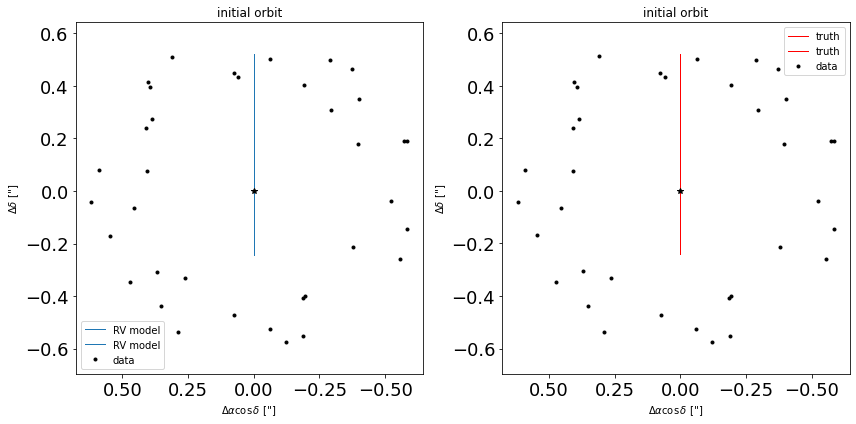

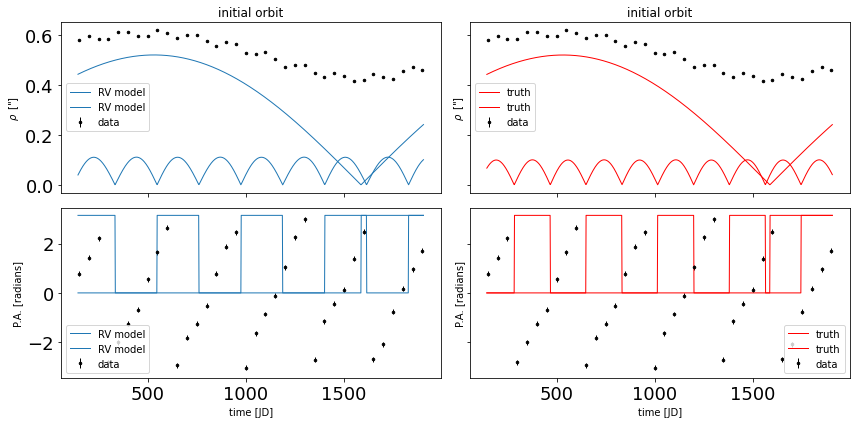

In [341]:

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
rho, theta = theano.function([], orbit.get_relative_angles(t_astrometry, parallax))()
rho_true, theta_true = theano.function([], orbit_true.get_relative_angles(t_astrometry, parallax))()


# Plot the orbit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax0, ax1 = ax[0], ax[1]

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax0.plot(ys, xs, color="C0", lw=1, label = "RV model")

xs_true = rho_true * np.cos(theta_true)  # X is north
ys_true = rho_true * np.sin(theta_true)  # Y is east
ax1.plot(ys_true, xs_true, color="r", lw=1, label = "truth")

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax0.plot(ys, xs, ".k", label = "data")
ax1.plot(ys, xs, ".k", label = "data")

ax0.set_ylabel(r"$\Delta \delta$ ['']")
ax0.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax0.invert_xaxis()
ax0.plot(0, 0, "k*")
ax0.set_aspect("equal", "datalim")
ax0.set_title("initial orbit")
ax0.legend()

ax1.set_ylabel(r"$\Delta \delta$ ['']")
ax1.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax1.invert_xaxis()
ax1.plot(0, 0, "k*")
ax1.set_aspect("equal", "datalim")
ax1.set_title("initial orbit")
ax1.legend()

fig.tight_layout()


fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', figsize=(12, 6))
ax[0][0].errorbar(x_astrometry, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5, label = "data")
ax[0][0].plot(t_astrometry, rho, color="C0", lw=1, label="RV model")
ax[0][0].set_ylabel(r'$\rho\,$ ["]')
ax[0][0].set_title("initial orbit")
ax[0][0].legend()

ax[0][1].errorbar(x_astrometry, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5, label = "data")
ax[0][1].plot(t_astrometry, rho_true, color="r", lw=1, label="truth")
ax[0][1].set_ylabel(r'$\rho\,$ ["]')
ax[0][1].set_title("initial orbit")
ax[0][1].legend()




ax[1][0].errorbar(x_astrometry, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5, label = "data")
ax[1][0].plot(t_astrometry, theta, color="C0", lw=1, label="RV model")
ax[1][0].set_ylabel(r"P.A. [radians]")
_ = ax[1][0].set_xlabel("time [JD]")
ax[1][0].legend()


ax[1][1].errorbar(x_astrometry, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5, label = "data")
ax[1][1].plot(t_astrometry, theta_true, color="r", lw=1, label="truth")
ax[1][1].set_ylabel(r"P.A. [radians]")
_ = ax[1][1].set_xlabel("time [JD]")
ax[1][1].legend()


fig.tight_layout()


In [342]:
print(P_RV)
print(min_masses_RV)
print(a_from_Kepler3(P_RV, 1.+min_masses_RV))

[ 427.02939948 4330.3962008 ]
[2.45168061e-08 3.27995366e-05]
[1.10978731 5.19945399]


In [343]:
def determine_phase(P, t_periastron):
    phase = (2 * np.pi * t_periastron) / P
    return phase

In [344]:
phase_RV = determine_phase(P_RV, tperi_RV)

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

 let's fold in RV data as well in the PyMC3 Model

### Define the PyMC3 Model

In [345]:

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)


def get_model():
    with pm.Model() as model:


        # Below we will run a version of this model where a measurement of parallax is provided
        # The measurement is in milliarcsec
        m_plx = pm.Bound(pm.Normal, lower=0, upper=200)(
            "m_plx", mu=parallax*1000, sd=10, testval=parallax*1000
        )
        plx = pm.Deterministic("plx", 1e-3 * m_plx)


        # We expect the period to be around that found from just the RVs,
        # so we'll set a broad prior on logP
        
        logP = pm.Uniform(
            "logP", lower=0, upper=np.log(10000.), testval=np.log(P_RV), shape=2
        )
        P = pm.Deterministic("P", tt.exp(logP))
        
        # Eccentricity & argument of periasteron
        ecs = pmx.UnitDisk("ecs", shape=(2, 2), 
                           testval=np.array([ecc_RV*np.cos(omega_RV), 
                                             ecc_RV*np.sin(omega_RV)]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        
        # Omegas are co-dependent, so sample them with variables Omega_plus
        # and Omegas_minus. Omega_plus is (Omega_0 + Omega_1)/2 and 
        # Omega_minus is (Omega_0 - Omega_1)/2
        
     
        
        Omega_plus = pmx.Angle("Omega_plus", shape=1)
        Omega_minus = pmx.Angle("Omega_minus", shape=1)
        
        
        Omega = tt.concatenate( [(Omega_plus + Omega_minus),
                                 (Omega_plus - Omega_minus)] )
        

        Omega = pm.Deterministic("Omega", Omega) 
        Omega_sum = pm.Deterministic("Omega_sum", ((Omega_plus)*2)% np.pi)
        Omega_diff = pm.Deterministic("Omega_diff", ((Omega_minus)*2)% np.pi)
        

        
        # uniform prior on t0, with testval from RV fit
        #t0 = pm.Uniform("t0", lower=0, upper=10000., shape=2, testval = t0_RV)
    
        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = pmx.Angle("phase", testval=phase_RV, shape=2)
        tperi = pm.Deterministic("tperi", P * phase / (2 * np.pi))
        
        # uniform prior on sqrtm_sini and sqrtm_cosi
        sqrtm_sini = pm.Uniform("sqrtm_sini", lower=0, upper=500, 
                                testval = min_masses_RV[0]*m_sun, shape=2)
        
        sqrtm_cosi = pm.Uniform("sqrtm_cosi", lower=0, upper=500, 
                                testval = min_masses_RV[0]*m_sun, shape=2)
        
        
        m_planet = pm.Deterministic("m_planet", sqrtm_sini**2. + sqrtm_cosi**2.)
        m_planet_fit = pm.Deterministic("m_planet_fit", m_planet/m_sun)
        
        incl = pm.Deterministic("incl", tt.arctan2(sqrtm_sini, sqrtm_cosi))
        
        
        
        # add keplers 3 law function
        a = pm.Deterministic("a", a_from_Kepler3(P, 1.0+m_planet_fit))
        
        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
            m_planet = m_planet_fit,
            plx=plx
        )


        
        
        # Add a function for computing the full astrometry model
        def get_astrometry_model(t, name=""):
            # First the RVs induced by the planets
            rhos, thetas = orbit.get_relative_angles(t, plx)
            pm.Deterministic("rhos" + name, rhos)
            pm.Deterministic("thetas" + name, thetas)
            
            # Sum over planets and add the background to get the full model
            rho_model = pm.Deterministic("rho_model" + name, tt.sum(rhos, axis=-1))
            
            
            # when summing over theta, position angle, we have to careful because position
            # angle has the range -pi to pi. So for only summing 2 thetas, we can subtract 
            # 2pi whenever theta_sum > pi and add 2pi whenever theta_sum < -pi to get back
            # in the correct range. Be careful though if modeling more than 2 planets, this
            # doesn't completely solve the problem!
            thetas_sum = tt.sum(thetas, axis=-1)
            thetas_sum = tt.switch(tt.lt(thetas_sum,-np.pi), thetas_sum+2*np.pi, thetas_sum)
            thetas_sum = tt.switch(tt.gt(thetas_sum, np.pi), thetas_sum-2*np.pi, thetas_sum)

            theta_model = pm.Deterministic("theta_model" + name, thetas_sum)
            

            
            return rho_model, theta_model

        
        # Define the astrometry model at the observed times
        rho_model, theta_model = get_astrometry_model(x_astrometry)

        # Also define the model on a fine grid as computed above (for plotting)
        rho_model_pred, theta_model_pred = get_astrometry_model(t_fine, name="_pred")

        

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=0.01
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=2.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        
        
        # ADD RV MODEL
        # Jitter & a quadratic RV trend
        log_rv = pm.Normal("log_rv", mu=np.log(np.median(y_rv_err)), sd=0.01)


        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Sum over planets and add the background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))

        # Define the RVs at the observed times
        rv_model = get_rv_model(x_rv)

        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t, name="_pred")

        # Finally add in the observation model. This next line adds a new contribution
        # to the log probability of the PyMC3 model
        rv_err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * log_rv))
        pm.Normal("obs_RV", mu=rv_model, sd=rv_err, observed=y_rv)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, vars=[sqrtm_cosi, sqrtm_sini])
        map_soln = pmx.optimize(map_soln, vars=[phase])
        map_soln = pmx.optimize(map_soln, vars=[Omega, ecs])
        map_soln = pmx.optimize(map_soln, vars=[P, a, phase])
        map_soln = pmx.optimize(map_soln)


    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [sqrtm_sini, sqrtm_cosi]


message: Desired error not necessarily achieved due to precision loss.
logp: -333035788.072603 -> -646145.3574084898
optimizing logp for variables: [phase]


message: Desired error not necessarily achieved due to precision loss.
logp: -646145.3574084898 -> -614874.2535451639
optimizing logp for variables: [ecs, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -614874.2535451639 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [phase, sqrtm_sini, sqrtm_cosi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -614874.2535451639 -> -324364.00871279644
optimizing logp for variables: [log_rv, log_theta_s, log_rho_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -324364.00871279644 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


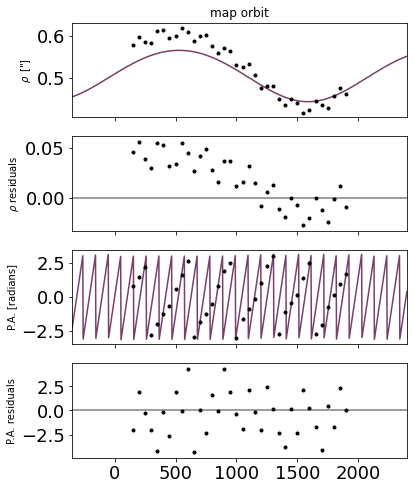

In [346]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_model_pred"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_model_pred"], color="#773f6a")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

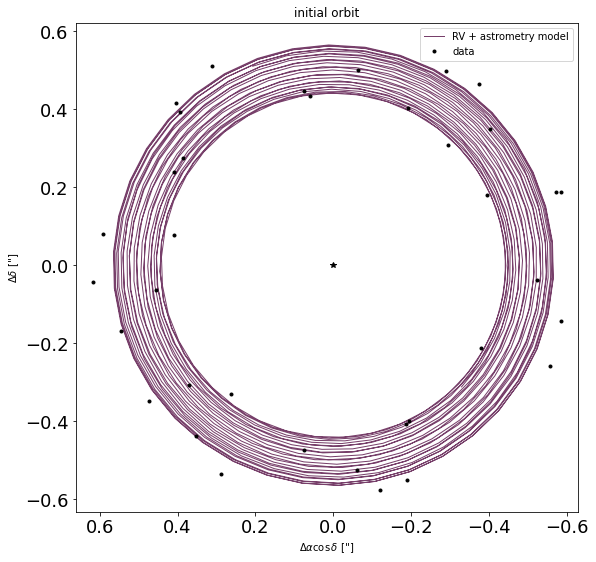

In [347]:
fig, ax = plt.subplots(1, figsize = [9,9])

xs = map_soln["rho_model_pred"] * np.cos(map_soln["theta_model_pred"])  # X is north
ys = map_soln["rho_model_pred"] * np.sin(map_soln["theta_model_pred"])  # Y is east
ax.plot(ys, xs, color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()


[ 106.66795779 4233.95044299]
[  16.55737727 1638.38896283]
115.52083329996094 1633.721527799964


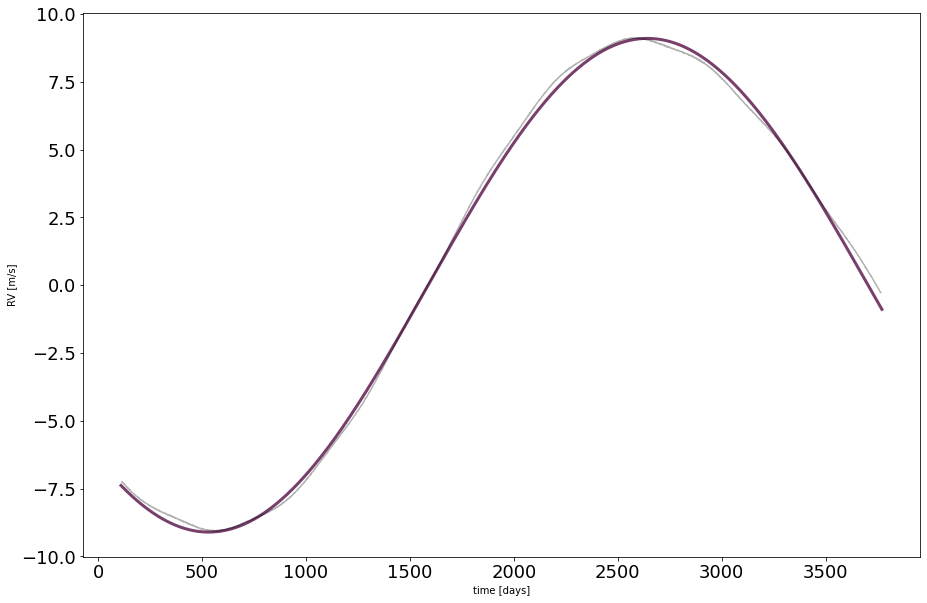

In [348]:
plt.figure(figsize=[15,10])
plt.plot(t, map_soln["rv_model_pred"],color="#773f6a", lw=3)
plt.plot(x_rv, y_rv, color='k', alpha=0.3)
plt.xlabel("time [days]")
plt.ylabel("RV [m/s]")
print(map_soln["P"])
print(map_soln["tperi"])
print(Tper_earth,Tper_jup)

Now let's sample the posterior.

In [349]:
print(map_soln['tperi'])
print(map_soln['P'])
print(map_soln['ecc'])
print(map_soln['omega'])
print(map_soln['m_planet_fit'])
print(map_soln['Omega'])
print(map_soln['incl'])
    
print("")
print(Tper_earth, Tper_jup)
print(P_earth, P_jup)
print(e_earth, e_jup)
print(omega_earth, omega_jup)
print(m_earth, m_jup)
print(Omega_earth, Omega_jup)
print(inclination_earth, inclination_jup)

[  16.55737727 1638.38896283]
[ 106.66795779 4233.95044299]
[0.00082189 0.00238026]
[-1.5013775  -1.49527448]
[0.75037635 0.00106609]
[0. 0.]
[5.18724473e-09 7.06594706e-01]

115.52083329996094 1633.721527799964
365.256 4327.631
0.0167 0.0484
1.7959438003021653 -1.4957471689591397
3.00273e-06 0.0009543576759
0.0 1.7523105690023069
0.7853981633974483 0.808261976598574


In [350]:
np.random.seed(1234)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_rv, log_theta_s, log_rho_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


ValueError: Not enough samples to build a trace.

First we can check the convergence for some of the key parameters.

In [ ]:
import arviz as az

az.summary(
    trace,
    var_names=["P", "tperi", "omega", "Omega_sum", "Omega_plus", "Omega_minus", 
               "incl", "ecc", "plx", "m_planet", "a"],
)



In [ ]:
pm.traceplot(trace, var_names=["P", "tperi", "omega", "Omega_sum", "Omega_plus", "Omega_minus", "incl", 
                               "ecc", "plx", "m_planet", "a"])


In [ ]:
truth_both = [P_earth, P_jup, e_earth, e_jup, omega_earth, omega_jup, Omega_earth+Omega_jup, Omega_earth-Omega_jup, 
              inclination_earth, inclination_jup, 0.1, m_earth*m_sun, m_jup*m_sun, a_true_earth, a_true_jup]

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

In [ ]:
import corner

_ = corner.corner(
    trace, var_names=["P", "ecc", "omega", "Omega_sum", "Omega_minus", "incl", 
                      "plx", "m_planet", "a"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}, 
                       truths = truth_both, truth_color = "#03003a"
)

In [ ]:
import corner

_ = corner.corner(
    trace, var_names=["Omega_plus", "Omega_sum", "Omega_minus", "Omega"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}
)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

In [ ]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 9))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel(r"time [days]")

tot_rho_err = np.sqrt(
    rho_err ** 2
    + np.exp(2 * np.median(trace.posterior["log_rho_s"].values, axis=(0, 1)))
)
tot_theta_err = np.sqrt(
    theta_err ** 2
    + np.exp(2 * np.median(trace.posterior["log_theta_s"].values, axis=(0, 1)))
)

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace.posterior["rho_model_pred"].values, [16, 84], axis=(0, 1))
ax[0].fill_between(t_fine, q[0], q[1], color="#773f6a", alpha=0.8, lw=1)

ax[1].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace.posterior["theta_model_pred"].values, [16, 84], axis=(0, 1))
ax[1].fill_between(t_fine, q[0], q[1], color="#773f6a", alpha=0.8, lw=1)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

In [ ]:
# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))

fig, ax = plt.subplots(1,2, figsize = [15,10], sharey=True)

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.3, label='data', zorder = 0)
ax[0].plot(t, pred[1], color="#773f6a", label="model", zorder = 1)
art = ax[0].fill_between(t, pred[0], pred[2], color="#773f6a", alpha=0.3)
art.set_edgecolor("none")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MCMC posterior and data")




ax[1].plot(t, pred[1], color="#773f6a", label="model")
art = ax[1].fill_between(t, pred[0], pred[2], color="#773f6a", alpha=0.3)
art.set_edgecolor("none")

ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")



plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

In [ ]:
parameters = ["P", "ecc", "omega", "Omega", "incl", "m_planet", "a", "tperi"]
param_medians = {}
param_std = {}
posterior1 = {}
posterior2 = {}
for param in parameters:
    
    posterior1[param]=np.concatenate(trace.posterior[param].values[:, :, 0])
    posterior2[param]=np.concatenate(trace.posterior[param].values[:, :, 1])
    
    print(param + " median")
    planet1_med = np.median(trace.posterior[param].values[:, :, 0])
    planet2_med = np.median(trace.posterior[param].values[:, :, 1])
    print(planet1_med)
    print(planet2_med)
    print("")
    
    print(param + " stdev")
    planet1_std = np.std(trace.posterior[param].values[:, :, 0])
    planet2_std = np.std(trace.posterior[param].values[:, :, 1])
    print(planet1_std)
    print(planet2_std)
    
    param_medians[param]=[planet1_med, planet2_med]
    param_std[param]=[planet1_std, planet2_std]
    print("")
    print("")
    

    

    
    
print("plx median")
planet1_med = np.median(trace.posterior["plx"].values[:, :,])
planet2_med = np.median(trace.posterior["plx"].values[:, :,])
print(planet1_med)
print(planet2_med)
print("")

print("plx stdev")
planet1_std = np.std(trace.posterior["plx"].values[:, :])
planet2_std = np.std(trace.posterior["plx"].values[:, :])
print(planet1_std)
print(planet2_std)

param_medians["plx"]=[planet1_med, planet2_med]
param_std["plx"]=[planet1_std, planet2_std]
print("")
print("")


